In [182]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [183]:
data = pd.read_csv("telecom_users.csv")
data

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,3772,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95,Yes
5982,5191,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.3,No
5983,5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5984,5390,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes


In [184]:
#общая статистика по данным

print("Всего клиентов в базе:", len(data))
print("Распределение мужчин и женщин:", data.groupby('gender')['customerID'].count())
print("Количество ушедших абонентов:", data.groupby('Churn')['customerID'].count()[1])
print("Процент оттока:", int(data.groupby('Churn')['customerID'].count()[1]/len(data)*100))
print("Деньги, которые потеряны из-за оттока/мес:",int(data.groupby('Churn')['MonthlyCharges'].sum()[1]))
print("Деньги, получаемые от действующих клиентов/мес:",int(data.groupby('Churn')['MonthlyCharges'].sum()[0]))
print("Медианный тариф у подключенных пользователей/мес:", int(data.groupby('Churn')['MonthlyCharges'].median()[0]))
print("Медианный тариф у отключенных пользователей/мес:", int(data.groupby('Churn')['MonthlyCharges'].median()[1]))
print("Среднее время пользования у подключенных пользователей(мес):", int(data.groupby('Churn')['tenure'].mean()[0]))
print("Среднее время пользования у ушедших пользователей(мес):", int(data.groupby('Churn')['tenure'].mean()[1]))
print("Процент клиентов, которые не пользуются интернетом:", int(data.groupby('InternetService')['customerID'].count()[2]/len(data)*100))
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)
print("Среднее количество денег от одного абонента:", data['TotalCharges'].sum()/len(data))
print("Общее количество денег:", data['TotalCharges'].sum())

data.info()


Всего клиентов в базе: 5986
Распределение мужчин и женщин: gender
Female    2936
Male      3050
Name: customerID, dtype: int64
Количество ушедших абонентов: 1587
Процент оттока: 26
Деньги, которые потеряны из-за оттока/мес: 117699
Деньги, получаемые от действующих клиентов/мес: 270206
Медианный тариф у подключенных пользователей/мес: 64
Медианный тариф у отключенных пользователей/мес: 79
Среднее время пользования у подключенных пользователей(мес): 37
Среднее время пользования у ушедших пользователей(мес): 18
Процент клиентов, которые не пользуются интернетом: 21
Среднее количество денег от одного абонента: 2294.2215586368193
Общее количество денег: 13733210.25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
Unnamed: 0          5986 non-null int64
customerID          5986 non-null object
gender              5986 non-null object
SeniorCitizen       5986 non-null int64
Partner             5986 non-null object
Dependents          5

In [185]:
#подготавливаем данные для машинного обучения

data = data.drop(columns = ['customerID', 'Unnamed: 0'])

features = data.copy()

        
# выбираем категорильные колонки
categorical_subset = data[['gender', 'Partner','Dependents','PhoneService','MultipleLines','InternetService',
                           'DeviceProtection', 'TechSupport','StreamingTV','StreamingMovies','Contract',
                           'PaperlessBilling','PaymentMethod','SeniorCitizen','OnlineSecurity','OnlineBackup']]

# преобразые категорильные в бинарные
categorical_subset = pd.get_dummies(categorical_subset)

# объединяем датасеты
features = pd.concat([data, categorical_subset], axis = 1)



features['Leave'] = features['Churn'].apply(lambda x: 0 if x == 'No' else 1)
features = features.drop(['gender', 'Partner','Dependents','PhoneService','MultipleLines','InternetService',
                           'DeviceProtection', 'TechSupport','StreamingTV','StreamingMovies','Contract',
                           'PaperlessBilling','PaymentMethod','SeniorCitizen','Churn','OnlineSecurity','OnlineBackup'], axis = 1)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 45 columns):
tenure                                     5986 non-null int64
MonthlyCharges                             5986 non-null float64
TotalCharges                               5986 non-null float64
gender_Female                              5986 non-null uint8
gender_Male                                5986 non-null uint8
Partner_No                                 5986 non-null uint8
Partner_Yes                                5986 non-null uint8
Dependents_No                              5986 non-null uint8
Dependents_Yes                             5986 non-null uint8
PhoneService_No                            5986 non-null uint8
PhoneService_Yes                           5986 non-null uint8
MultipleLines_No                           5986 non-null uint8
MultipleLines_No phone service             5986 non-null uint8
MultipleLines_Yes                          5986 non-null uint8
Interne

In [186]:
#подготавливаем данные для выявления закономерностей

#оцифровываем пол, 0 - мужчины, 1 - женщины
data['gender'] = data['gender'].apply(lambda x: 0 if x == 'Male' else 1)
#оцифровываем личный статус, 0 - нет партнера, 1 - есть
data['Partner'] = data['Partner'].apply(lambda x: 0 if x == 'No' else 1)
#1 - есть иждевенец, 0 - нет
data['Dependents'] = data['Dependents'].apply(lambda x: 0 if x == 'No' else 1)
#0 - пол года работает, 1 - от полугода до двух лет, 2 - от двух до пяти лет, 3 - от 5-ти лет и больше
# data['tenure'] = data['tenure'].apply(lambda x: 0 if x <= 6 
#                                       else(1 if 6 < x <= 24 
#                                            else (2 if 24 < x <= 60 
#                                                  else 3)))
#1 - подключена телефония, 0 - нет
data['PhoneService'] = data['PhoneService'].apply(lambda x: 0 if x == 'No' else 1)
#2 - есть телефонные линии, 1 - только одна линия, 0 - нет телефонии
data['MultipleLines'] = data['MultipleLines'].apply(lambda x: 2 if x == 'Yes' else (1 if x == 'No' else 0))
#0 - нет интернета, 1 - есть интернет по ADSL, 2 - есть интернет по оптике
data['InternetService'] = data['InternetService'].apply(lambda x: 0 if x == 'No' else (1 if x == "DSL" else 2))
#2 - есть услуга онлайн-безопасности, 1 - нет услуги, 0 - нет интернета
data['OnlineSecurity'] = data['OnlineSecurity'].apply(lambda x: 1 if x == 'Yes' else 0)
#1- есть услуга бэкапа, 0 - нет услуги или интернета
data['OnlineBackup'] = data['OnlineBackup'].apply(lambda x: 1 if x == 'Yes' else 0)
#1- есть услуга бэкапа, 0 - нет услуги или интернета
data['DeviceProtection'] = data['DeviceProtection'].apply(lambda x: 1 if x == 'Yes' else 0)
#1- есть услуга бэкапа, 0 - нет услуги или интернета
data['StreamingTV'] = data['StreamingTV'].apply(lambda x: 1 if x == 'Yes' else 0)
#1- есть услуга бэкапа, 0 - нет услуги или интернета
data['TechSupport'] = data['TechSupport'].apply(lambda x: 1 if x == 'Yes' else 0)
#1- есть услуга бэкапа, 0 - нет услуги или интернета
data['StreamingMovies'] = data['StreamingMovies'].apply(lambda x: 1 if x == 'Yes' else 0)
#2 - контракт на 2 года, 1 - контракт на год, 0 - контракт ежемесячный
data['Contract'] = data['Contract'].apply(lambda x: 2 if x == 'Two year' else (1 if x == 'One year' else 0))
#0 - нет безмумажного биллинга, 1 - есть
data['PaperlessBilling'] = data['PaperlessBilling'].apply(lambda x: 0 if x == 'No' else 1)
#0 - Эдектронный чек, 1 - почттовый чек, 2 - банк трансфер, 3 - кредитная карта
data['PaymentMethod'] = data['PaymentMethod'].apply(lambda x: 0 if x == 'Electronic check' 
                                      else(1 if x == 'Mailed check' 
                                           else (2 if x == 'Bank transfer (automatic)' 
                                                 else 3)))
# #месячный платеж: 0 - меньше 25 долларов, 1 - 25-75 долларов, 2 - больше 75 долларов
# data['MonthlyCharges'] = data['MonthlyCharges'].apply(lambda x: 0 if x <= 25 
#                                       else(1 if 25 > x <= 75 
#                                            else 2))
# #общее количество денег который принес клиент: 0 - до 100 баксов, 1 - от 100 до 500, 2 - от 500 до 2000, 3 - больше 2000
# data['TotalCharges'] = data['TotalCharges'].apply(lambda x: 0 if x <= 100 
#                                       else(1 if 100 > x <= 500 
#                                            else (2 if 500 < x <= 2000 
#                                                  else 3)))
#ушел ли клиент: 0 - нет, 1 - да
data['Leave'] = data['Churn'].apply(lambda x: 0 if x == 'No' else 1)
data = data.drop(['Churn'], axis = 1)
data



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Leave
0,0,0,1,1,72,1,2,0,0,0,0,0,0,0,2,0,3,24.10,1734.65,0
1,1,0,0,0,44,1,1,2,0,1,1,0,1,0,0,1,3,88.15,3973.20,0
2,1,1,1,0,38,1,2,2,0,0,0,0,0,0,0,1,2,74.95,2869.85,1
3,0,0,0,0,4,1,1,1,0,0,0,0,0,1,0,1,0,55.90,238.50,0
4,0,0,0,0,2,1,1,1,1,0,1,0,0,0,0,0,0,53.45,119.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,0,0,1,0,1,1,1,2,1,0,0,0,1,1,0,1,0,95.00,95.00,1
5982,1,0,1,1,23,1,2,1,1,1,1,1,1,1,2,1,3,91.10,2198.30,0
5983,0,0,1,1,12,1,1,0,0,0,0,0,0,0,0,1,0,21.15,306.05,0
5984,0,1,0,0,12,1,2,2,0,0,1,0,1,1,0,1,0,99.45,1200.15,1


In [187]:
#убираем лишние столбцы и берем для гипотез только ушедших пользователей

hypoth = data[data['Leave'] == 1]

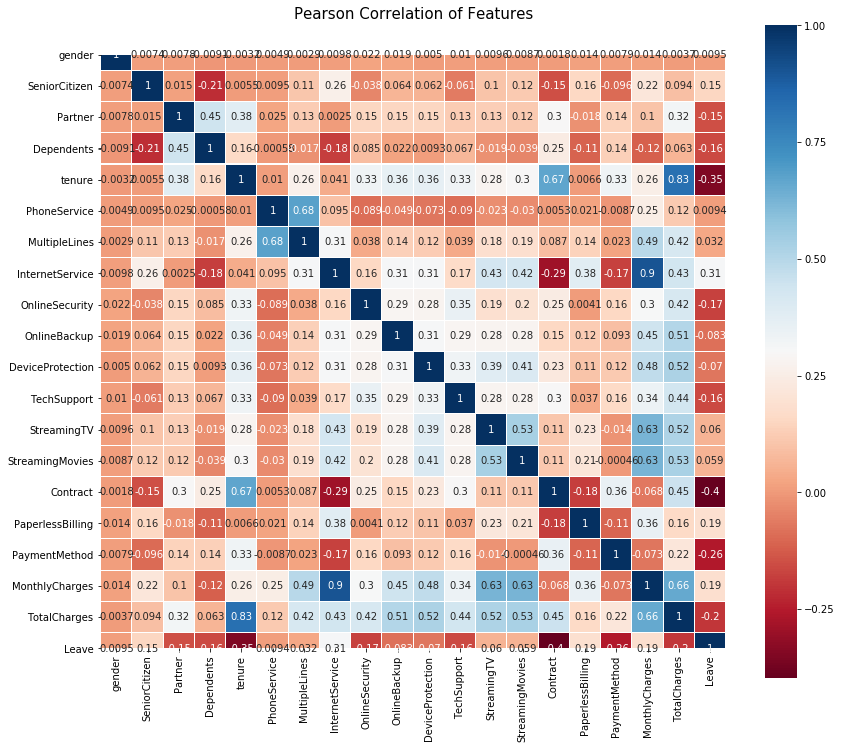

In [188]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#составляем корреляционную матрицу. Нас итересует в первую очередь зависимость относительно метрики Leave.
#Видим небольшую зависимость между оттоком и наличием или отсутствием интернет пканала у клиента, так же зависимость с видом контракта
#а так же со временем пользования услугами и методом платежа. 
#Есть еще гораздо меньшие зависимости с месячным платежом и бумажным биллингом (???), а так же подключенных услуг онлайн безопасности,
#технической поддержки, и наличием иждивенцев
#Относительно этих метрик мы и будем строить прогнозы


In [189]:
#смотрим списком какие корелляции особенно заметны

correlations = data.corr()['Leave'].dropna().sort_values()
print(correlations.head(10))
print(correlations.tail(10))

Contract           -0.396446
tenure             -0.348469
PaymentMethod      -0.259263
TotalCharges       -0.196390
OnlineSecurity     -0.174301
TechSupport        -0.161821
Dependents         -0.160204
Partner            -0.146840
OnlineBackup       -0.082648
DeviceProtection   -0.070000
Name: Leave, dtype: float64
PhoneService        0.009421
gender              0.009548
MultipleLines       0.032166
StreamingMovies     0.058865
StreamingTV         0.060379
SeniorCitizen       0.150097
MonthlyCharges      0.186753
PaperlessBilling    0.188996
InternetService     0.310417
Leave               1.000000
Name: Leave, dtype: float64


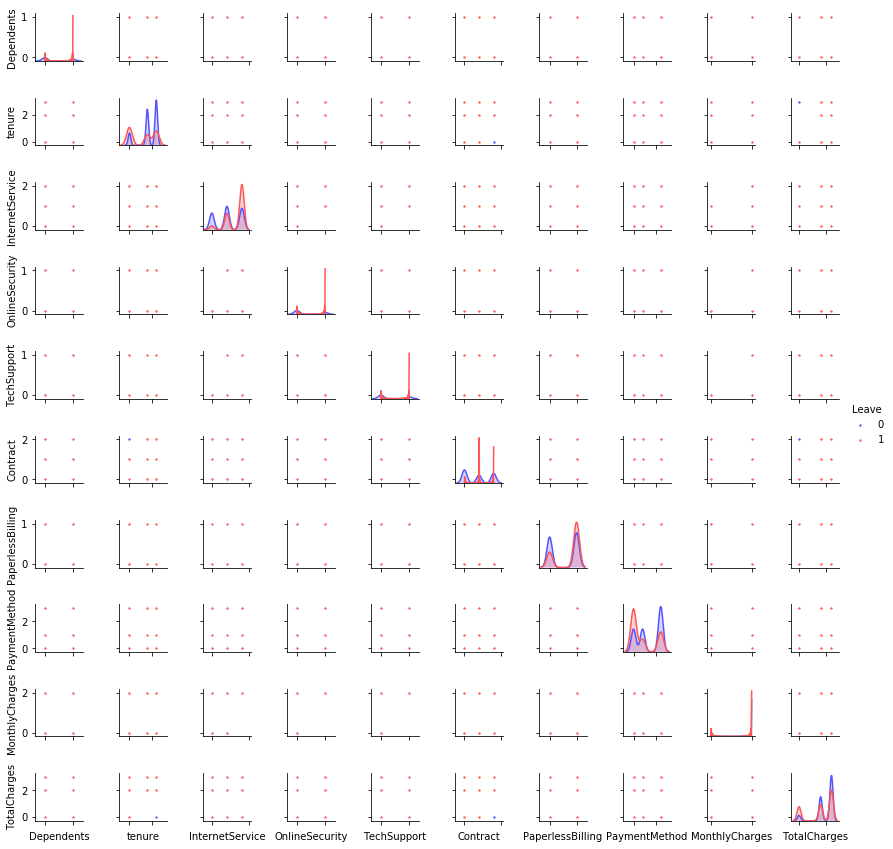

In [192]:
g = sns.pairplot(data, hue='Leave',vars = ['Dependents','tenure','InternetService','OnlineSecurity','TechSupport',
                       'Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges'], palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Text(0, 0.5, 'Количество отключений')

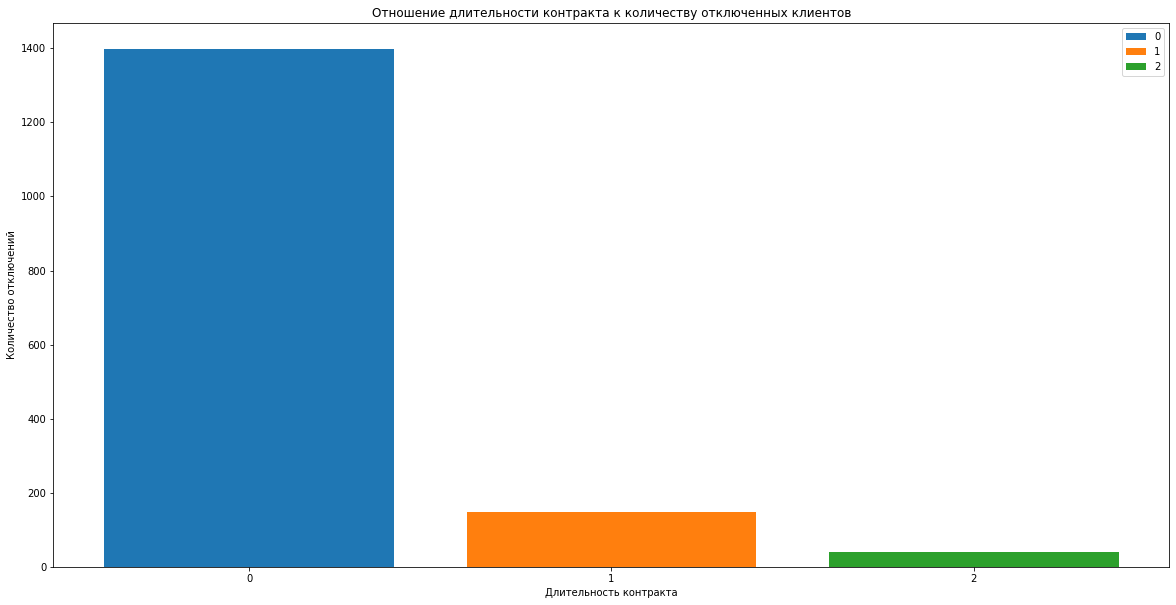

In [190]:
#Гипотеза 1: чем более длительный контракт заключен у клиента, тем меньше шансов что он уйдет от нас

fig, subplot1 = plt.subplots(figsize=(20,10))
for name, data in hypoth.groupby('Contract'):
    y = data['Leave'].sum()
    x = str(name)
    plt.bar(x, y, label = name)
plt.legend()
subplot1.set_title('Отношение длительности контракта к количеству отключенных клиентов')
subplot1.set_xlabel('Длительность контракта')
subplot1.set_ylabel('Количество отключений')

#действительно, мы видим, что те, кто заключают короткие контракты на месяц чаще всего отключаются, относительно других контрактов

Text(0, 0.5, 'Количество отключений')

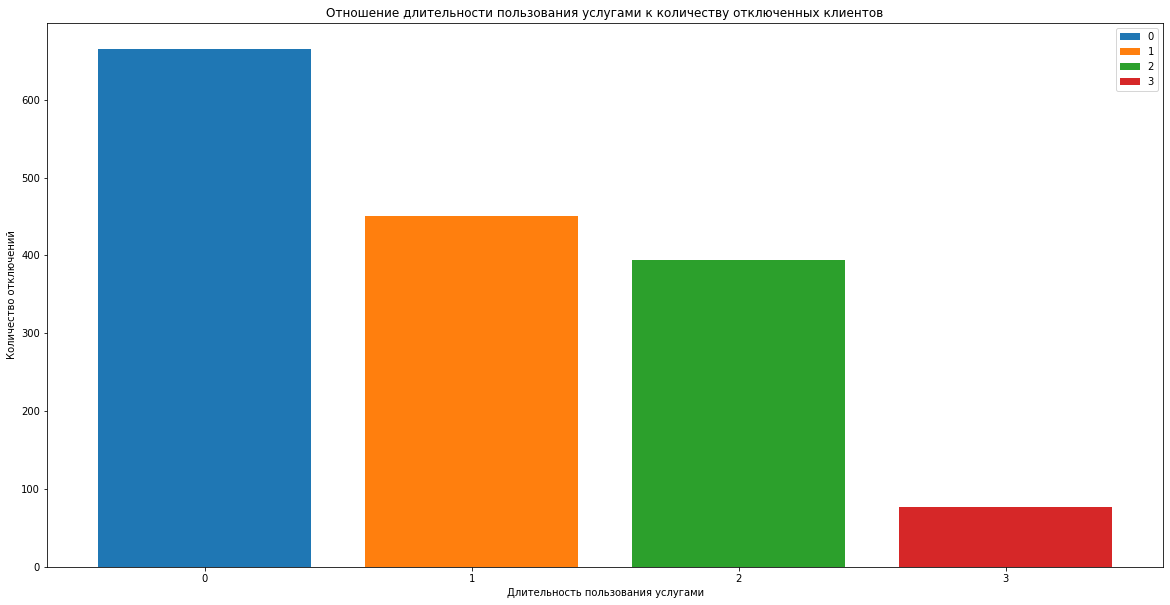

In [191]:
#Гипотеза 2: Чем дольше человек пользуется услугой, тем меньше вероятность что он отключится
hypoth['tenure'] = hypoth['tenure'].apply(lambda x: 0 if x <= 6 
                                      else(1 if 6 < x <= 24 
                                           else (2 if 24 < x <= 60 
                                                 else 3)))

fig, subplot2 = plt.subplots(figsize=(20,10))
for name, data in hypoth.groupby('tenure'):
    y = data['Leave'].sum()
    x = str(name)
    plt.bar(x, y, label = name)
plt.legend()
subplot2.set_title('Отношение длительности пользования услугами к количеству отключенных клиентов')
subplot2.set_xlabel('Длительность пользования услугами')
subplot2.set_ylabel('Количество отключений')


#как мы видим, гипотеза подтверждается, чем меньше человек пользуется услугами, тем больше вероятность его отключения

Text(0, 0.5, 'Количество отключений')

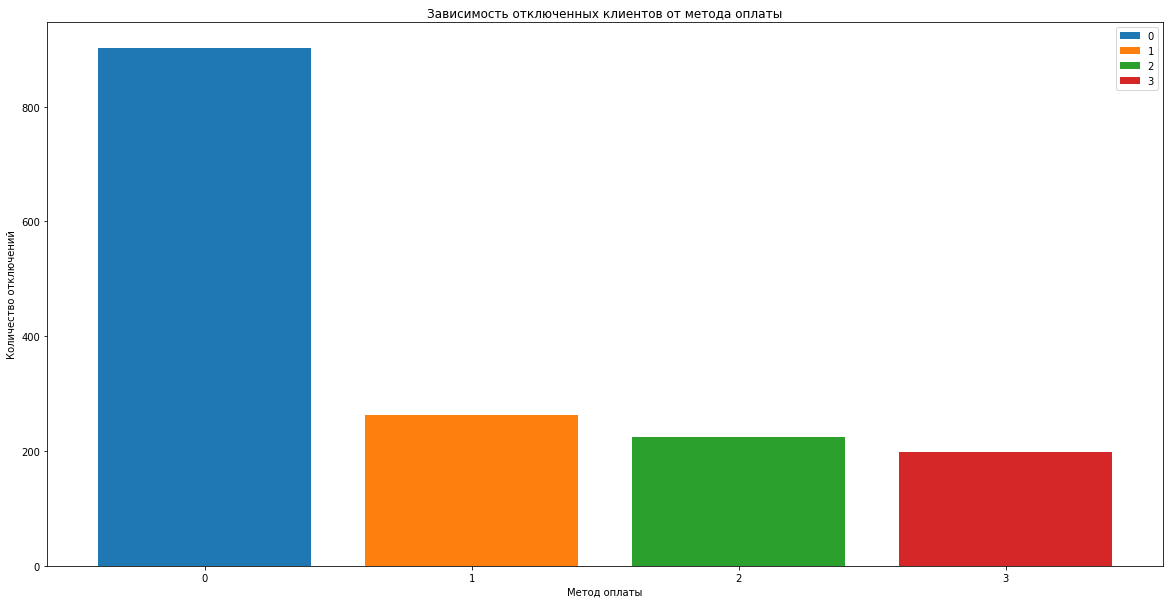

In [192]:
#Гипотеза 3: Если у человека настроен автоматический метод оплаты, то меньше шансов что он откажется от услуг

fig, subplot3 = plt.subplots(figsize=(20,10))
for name, data in hypoth.groupby('PaymentMethod'):
    y = data['Leave'].sum()
    x = str(name)
    plt.bar(x, y, label = name)
plt.legend()
subplot3.set_title('Зависимость отключенных клиентов от метода оплаты')
subplot3.set_xlabel('Метод оплаты')
subplot3.set_ylabel('Количество отключений')

#как мы видим, люди с видом платежа Электронный счет отключаются гораздо чаще других!

In [193]:
#берем функцию, которая перебирает признаки между собой, и удаляет те, которые коррелируются друг с другом больше чем на 0.6
#это необходимо чтобы еще сильнее повысить качество модели

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    y = x['Leave']
    x = x.drop(columns = ['Leave'])
    
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            if val >= threshold:
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    
    x['Leave'] = y
               
    return x

features = remove_collinear_features(features, 0.6)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 26 columns):
tenure                                     5986 non-null int64
MonthlyCharges                             5986 non-null float64
gender_Female                              5986 non-null uint8
gender_Male                                5986 non-null uint8
Partner_No                                 5986 non-null uint8
Partner_Yes                                5986 non-null uint8
Dependents_No                              5986 non-null uint8
Dependents_Yes                             5986 non-null uint8
PhoneService_No                            5986 non-null uint8
PhoneService_Yes                           5986 non-null uint8
MultipleLines_No                           5986 non-null uint8
InternetService_DSL                        5986 non-null uint8
DeviceProtection_No                        5986 non-null uint8
TechSupport_No                             5986 non-null uint8
Streaming

In [194]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from xgboost import XGBClassifier

In [195]:
# Нужно выбрать исходный базовый уровень (naive baseline) — некое предположение, с которым мы будем сравнивать результаты работы моделей.
# Если они окажутся ниже базового уровня, мы будем считать, что машинное обучение неприменимо для решения этой задачи, 
# или что нужно попробовать иной подход.

def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

targets = features['Leave']
features = features.drop(columns='Leave')


x_train, x_test, y_train, y_test = train_test_split(features, targets, 
                                        test_size = 0.3, 
                                        random_state = 17)


# print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))


In [196]:
# масштабируем признаки
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [197]:
#используем основные методики для предсказания моделей: Линейная регрессия, дерева решений, метод опорных векторов, k-ближайших соседей,
#градиентный бустинг. Данные методы являются самыми популярными и способны удовлетворить любые потребности.
# Линейная регрессия - имеет низкую точность, зато хорошо интерпретируется
# Дерево решений - быстрый и тоже хорошо интерпетируемый метод
# Метод ближайших соседей - быстро делает предсказания, имеет неплохую точность, но желательно использовать меньше переменных
# Метод опорных векторов - один из самых эффективных методов, обладает большой точностью, но зачастую слабо интерпретируется
# Случайный лес - это усовершенствованный вид дерева решений, позволяет улучшить результаты на нем
# Бустинг - это ансамбль алгоритмов, создание сильного алгоритма на основе семейства слабых


def fit_and_evaluate(model):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    model_score = np.mean(abs(y_test - model_pred))
    return model_score



LR = LogisticRegression(random_state = 17)
RFR = RandomForestRegressor(random_state = 17)
KNN = KNeighborsClassifier(n_neighbors=4)
SVC = SVC(random_state=17)

XGB = XGBClassifier(random_state = 17)

models = [LR, RFR, KNN, SVC, XGB]

for model in models:
    model_score = fit_and_evaluate(model)
    print('Score for {} model is: {}'.format(model, model_score))



# для измерения качества модели я использую среднюю величину между предсказанными и тестовыми значениями.
# лучше всех себя показала логистическая регрессия, ее и возьму для дальнейшего улучшения





Score for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) model is: 0.20489977728285078
Score for RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=17, verbose=0,
                      warm_start=False) model is: 0.27347253155159684
Score for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None,

In [198]:
#вычислим auc_score для Логистической регрессии

model_pred = LR.predict_proba(x_test)

auc_score = roc_auc_score(y_test, model_pred[:,1])
auc_score

0.8287924238894067

In [199]:
#подберем гиперпараметры для перебора

hyperparameter_grid = {
    'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'solver':['newton-cg', 'lbfgs', 'sag', 'saga','warn'],
    'max_iter':[10,20,30,40,50,60,70,80,90,100],
    'multi_class':['auto', 'ovr', 'warn']}

model = LogisticRegression(random_state = 17)

In [175]:
#подберем лучшие параметры для лучшей модели и сразу обучимся на них
random_cv = RandomizedSearchCV(estimator=model,
    param_distributions=hyperparameter_grid,
    cv=5, n_iter=25, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=17)

random_cv.fit(x_train, y_train)

random_cv.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    6.8s finished


LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [178]:
#делаем предсказания для лучших параметров, получили оценку почти не отличимую от прежней
best_predict = random_cv.predict_proba(x_test)
auc_score1 = roc_auc_score(y_test, best_predict[:,1])
auc_score1

0.8286273881640261

In [179]:
#попробуем подобрать параметры с помощью GridSearch, сразу обучим модель и получим оценку. Оценка незначительно ухудшилась...
clf = GridSearchCV(model, hyperparameter_grid)
clf.fit(x_train, y_train)

clf_predict = clf.predict_proba(x_test)

auc_score1 = roc_auc_score(y_test, clf_predict[:,1])
auc_score1

0.8278216255048152

In [ ]:
#Таким образом лучше всего себя показала Логистическая регрессия. На ней стоит и остановиться. Рузельтат получился 0.8286273881640261